<b><font size=3> Programming Exercise 7 | K-means Clustering and Principal Component Analysis </b></font>

In this exercise, we will implement the K-means clustering algorithm and apply it to compress an image. 

In [112]:
import os 
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm # Used to display images in a specific colormap
import matplotlib.gridspec as gridspec
%matplotlib inline

import scipy as sp
from scipy.io import loadmat
from sklearn.cluster import KMeans

In [113]:
os.chdir('/Users/christinakouride/Documents/Python/Learning/Andrew Ng - ML course/ex7')

data1 = sp.io.loadmat('ex7data2.mat')
data1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [114]:
X1 = data1['X']
X1.shape

(300, 2)

<b> 1. K-means Clustering </b>

<b> 1.1 Implementing K-means </b>

<b> 1.1.1 | Finding closest centroids (cluster assignment) </b>

In [115]:
# manual initialisation of K as indicated in ex7.m
K = 3
initial_centroids = np.array(([3,3], [6,2], [8, 5]))

In [116]:
def findClosestCentroids(X,initial_centroids):
    
    m = X.shape[0]
    K = initial_centroids.shape[0]
    
    idx = np.zeros(X.shape[0])
    distances = np.zeros(initial_centroids.shape[0])
    
    for i in range(m):
        for k in range(K):
            distances[k] = np.sum(sp.sqrt((X[i,0] - initial_centroids[k,0])**2+ (X[i,1] - initial_centroids[k,1])**2))
        
        idx[i] = distances.argmin()
        
    return idx

In [117]:
idx = findClosestCentroids(X1,initial_centroids)
idx[:3] + 1 #To correct for zero indexing

array([1., 3., 2.])

<b> 1.1.2 | Computing centroid means </b>

In [118]:
def computeCentroids(X, K, idx):
    
    centroids = []
    
    for k in range(K):

        centroids.append(sp.mean(X[idx == k], axis = 0))
        
    return centroids 

In [119]:
centroids = computeCentroids(X1, K, idx)
centroids

[array([2.42830111, 3.15792418]),
 array([5.81350331, 2.63365645]),
 array([7.11938687, 3.6166844 ])]

<b> 1.2 | K-means on example dataset <b/>

In [120]:
def plot_data(X, K, idx, axes = None):
    if axes == None:
        axes = plt.gca()

    color = iter( cm.rainbow( np.linspace( 0, 1, K ) ) )
    
    for k in range(K):
        p_in_cluster = (idx == k)
        c = next(color)
        axes.scatter( X[p_in_cluster][:,0], X[p_in_cluster][:,1], marker='o', s=30, 
                     edgecolors=c,facecolors='None', linewidth=0.4 )

In [121]:
def plot_centroids_path(X, K, idx, iterno, previous):
    axes = plt.gca() # get current axes
    
    K = initial_centroids.shape[0]
        
    plot_data(X, K, idx, axes)
    
    for j in range(previous.shape[1]):
        c_points = (previous[:,2] == j+1)
        axes.plot(previous[c_points][:,0], previous[c_points][:,1], 'kx--', markeredgewidth=2, markersize = 6, linewidth=1, label='centroids')
    axes.set_title( f'Iteration number {iterno+1}' )

In [122]:
def run_Kmeans(X, initial_centroids, max_iters, plot_progress):
    m = X.shape[0]
    K = initial_centroids.shape[0]
    previous_centroids = np.c_[ np.copy(initial_centroids), np.arange(1, K + 1) ]
    centroids = np.copy(initial_centroids)
    idx = np.zeros((m, 1))
    
    for iterno in range(max_iters):
        idx = findClosestCentroids( X, centroids )
        
        if plot_progress:
            plot_centroids_path(X, K, idx, iterno, previous_centroids)
                 
        centroids = np.c_[ computeCentroids( X, K, idx ), np.arange(1, K + 1) ]
        previous_centroids = np.concatenate( (previous_centroids, centroids), axis = 0)
    return (centroids[:,:centroids.shape[1]-1], idx)

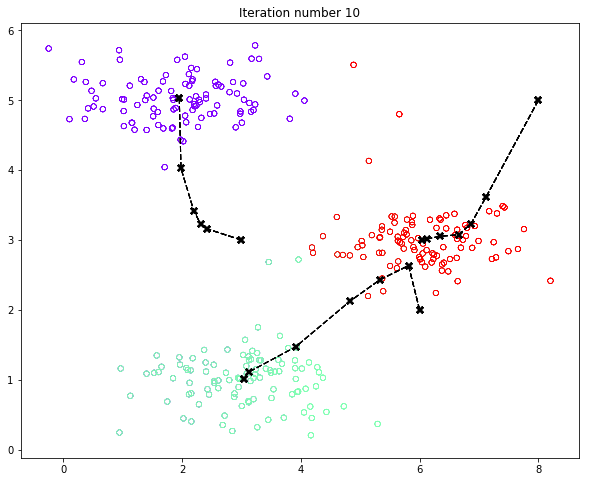

In [123]:
plt.figure(figsize=(10,8))
new_centroids, new_idx = run_Kmeans(X1, initial_centroids, 10, True)

In [124]:
new_centroids

array([[1.95399466, 5.02557006],
       [3.04367119, 1.01541041],
       [6.03366736, 3.00052511]])

<b>Compare with sklearn </b>

In [125]:
km1 = KMeans(3)
km1.fit(X1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [126]:
km1.cluster_centers_

array([[6.03366736, 3.00052511],
       [1.95399466, 5.02557006],
       [3.04367119, 1.01541041]])

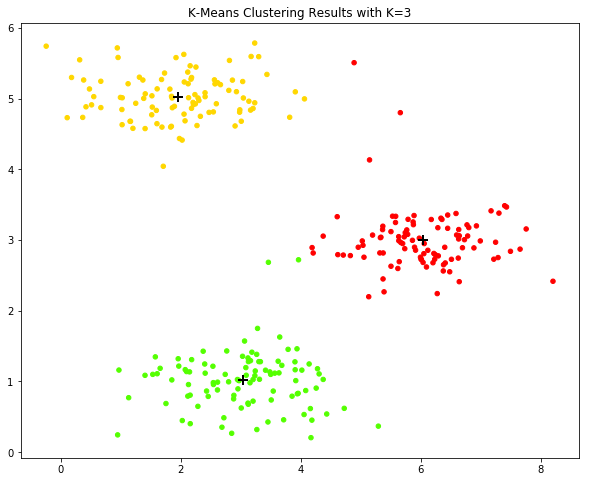

In [127]:
plt.figure(figsize=(10,8))
plt.scatter(X1[:,0], X1[:,1], s=20, c=km1.labels_, cmap=plt.cm.prism) 
plt.title('K-Means Clustering Results with K=3')
plt.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2);

<b> 1.3 | Random initialization </b>

In [128]:
def kMeansInitCentroids(X,K):
    np.random.shuffle(X)
    return X[:K,:]

In [129]:
kMeansInitCentroids(X1, K)

array([[0.99253246, 5.01567424],
       [6.88575584, 2.88845269],
       [2.20321658, 4.94516379]])

<b> 1.4 Image compression with K-means </b>

<b> 1.4.1 K-means on pixels </b>

(128, 128, 3)


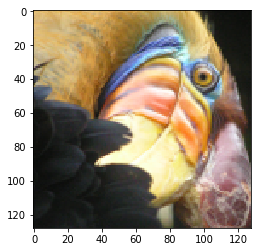

In [130]:
img = plt.imread('bird_small.png')
img_shape = img.shape
print(img_shape)
plt.imshow(img)

In [131]:
A = img.reshape(img_shape[0]*img_shape[1], img_shape[2])
A.shape

(16384, 3)

In [132]:
K = 16
max_iters = 10

In [133]:
initial_img_centroids = kMeansInitCentroids(np.copy(A), K)
img_centroids, img_idx = run_Kmeans(A, initial_img_centroids, max_iters, False)

In [134]:
print( 'centroids shape = ', img_centroids.shape)
print( 'indices shape = ', img_idx.shape)

centroids shape =  (16, 3)
indices shape =  (16384,)


In [135]:
img_idx= img_idx.astype(int)
img_idx

array([14, 14, 14, ...,  2, 10, 10])

In [136]:
X_recovered = img_centroids[img_idx,:]

In [137]:
#Reshape the recovered image into proper dimensions
X_recovered = X_recovered.reshape(img_shape[0], img_shape[1], img_shape[2])
X_recovered.shape

(128, 128, 3)

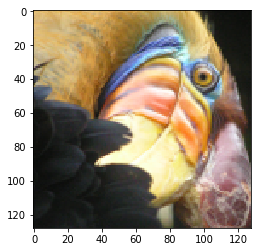

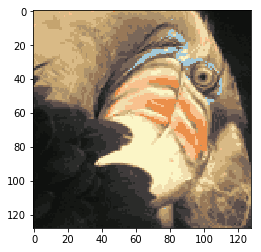

In [138]:
plt.figure()
plt.imshow(A.reshape(img_shape[0], img_shape[1], img_shape[2]))
plt.figure()
plt.imshow(X_recovered)

<b> 2 | Principal Component Analysis </b>

<b> 2.1 | Example Dataset</b>

In [139]:
data2 = sp.io.loadmat('ex7data1.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [140]:
X2 = data2['X']
X2.shape

(50, 2)

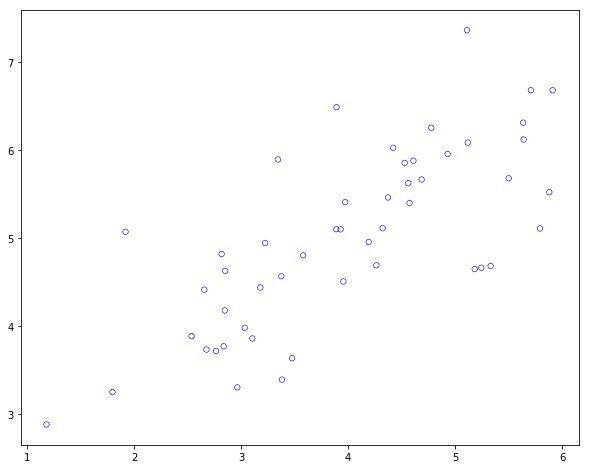

In [141]:
plt.figure(figsize=(10,8))
plt.scatter(X2[:,0],X2[:,1],marker = 'o',s=30, facecolors='None', edgecolors = 'b',linewidth=0.6)

<b> 2.2 | Implementing PCA</b>

In [142]:
def featureNormalize(Xs):
    
    n_features = Xs.shape[1]

    mu = np.array([np.mean(Xs[:,i]) for i in range(n_features)])
    sigma = np.array([np.std(Xs[:,i]) for i in range(n_features)])
    
    Xs = (Xs - mu)/sigma
    return Xs, mu, sigma

In [143]:
X2_norm, mu, sigma = featureNormalize(X2)

In [144]:
def pca(Xs):
    m = Xs.shape[0]
    S = (1/m)*np.dot(Xs.T,Xs)
    
    U, S, V = np.linalg.svd(S)
    
    return U, S

In [145]:
U,S = pca(X2_norm)
print("U: ",U)
print("S: ", S)

U:  [[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
S:  [1.73553038 0.26446962]


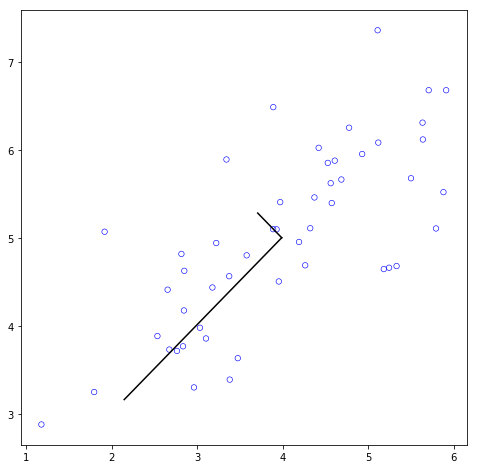

In [146]:
#Set appopriate ratio so that eigen vectors are orthogonal
plt.rcParams['figure.figsize'] = (8.0, 8.0)

plt.scatter(X2[:,0],X2[:,1],marker = 'o',s=30, facecolors='None', edgecolors = 'b',linewidth=0.6)

#Draw the eigenvectors centered at mean of data
plt.plot( np.append(mu[0], mu[0] + 1.5*S[0]*U[0,0]), np.append( mu[1], mu[1] + 1.5*S[0]*U[1,0] ),'k-', linewidth=1.5 )
plt.plot( np.append(mu[0], mu[0] + 1.5*S[1]*U[0,1]), np.append( mu[1], mu[1] + 1.5*S[1]*U[1,1] ), 'k-', linewidth=1.5 )

<b> 2.3 | Dimensionality Reduction with PCA</b>

<b>2.3.1 | Projecting the data onto the principal components</b>

In [147]:
def projectData(Xs, U, K):
    U_reduce = U[:, :K]
    Z = np.dot(Xs,U_reduce)
    return Z, U_reduce

In [148]:
K = 1
Z, U_reduce = projectData(X2_norm, U, K)

<b>2.3.2 | Reconstructing an approximation of the data</b>

In [149]:
def recoverData(Z, U, K):
    U_reduce = U[:, :K]
    X_rec = np.dot(Z, U_reduce.T)
    return X_rec

In [150]:
X2_rec = recoverData(Z, U, K)
X2_rec[0]

array([-1.05805279, -1.05805279])

<b>2.3.3 | Visualizing the projections</b>

(-4, 3)

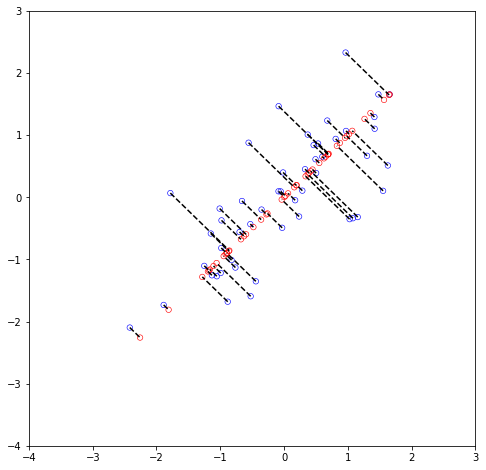

In [151]:
#plot original data
plt.scatter(X2_norm[:,0],X2_norm[:,1],marker = 'o',s=30, facecolors='None', edgecolors = 'b',linewidth=0.6)

#plot projected data
plt.scatter(X2_rec[:,0],X2_rec[:,1],marker = 'o',s=30, facecolors='None', edgecolors = 'r',linewidth=0.6)

#plot the projection path of each data point
m = X2_norm.shape[0]

for i in range(m):
    plt.plot((X2_norm[i,0], X2_rec[i,0]),(X2_norm[i,1], X2_rec[i,1]),'k--')
    
plt.ylim(-4,3)
plt.xlim(-4,3)

<b> 2.4 | Face Image Dataset</b>

In [152]:
data_faces = sp.io.loadmat('ex7faces.mat')
data_faces.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [153]:
X_faces = data_faces['X']
X_faces.shape
#each row corresponds to one face image, 32 x 32 in grayscale

(5000, 1024)

In [154]:
def displayData(Xs, nrows, ncols):
    """
    DisplayData picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    n = Xs.shape[1]
    
    fig = plt.figure(figsize=(10, 10))

    gs = gridspec.GridSpec(nrows, ncols)

    k = 0
    for i in range(nrows):
        for j in range(ncols):
            ax = plt.subplot(gs[i, j])
            ax.axis('off')
            ax.imshow(-Xs[k].reshape(int(sp.sqrt(n)), int(sp.sqrt(n))).T,
                     cmap=plt.get_cmap('Greys'))
            k += 1

    plt.show()

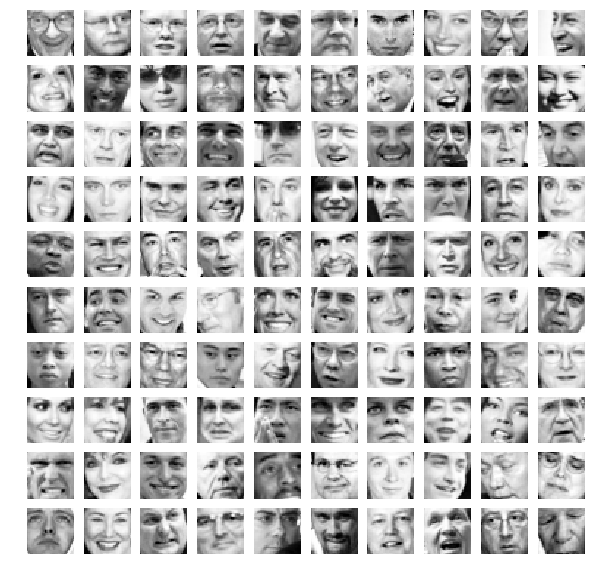

In [155]:
displayData(X_faces, 10, 10)

<b>2.4.1 | PCA on Faces</b>

In [156]:
X_faces_norm, mu, sigma = featureNormalize(X_faces)
U,S = pca(X_faces_norm)
U.shape

(1024, 1024)

<b>2.4.2 | Dimensionality Reduction</b>

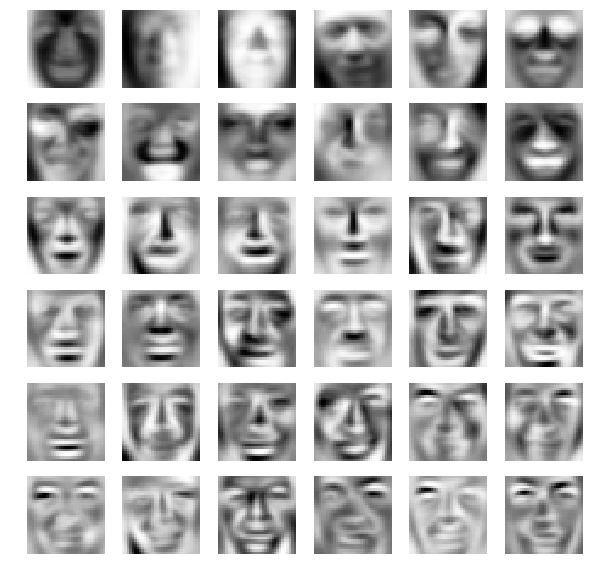

In [157]:
displayData(U[:,:36].T, 6, 6)

In [158]:
K = 100
Z, U_reduce = projectData(X_faces_norm, U, K)
X_faces_rec = recoverData(Z, U, K)

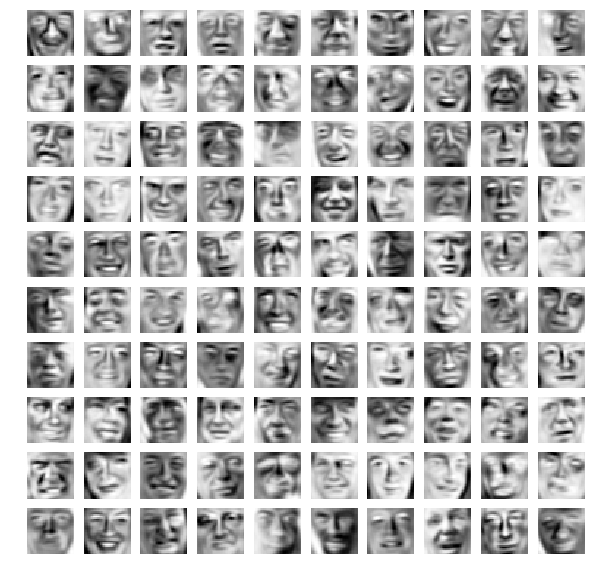

In [159]:
displayData(X_faces_rec, 10, 10)

<b>2.5 | Optional (ungraded) exercise: PCA for visualization</b>


In [160]:
A.shape

(16384, 3)

In [161]:
img_idx.shape

(16384,)

In [162]:
A_img_norm, mu_img, sigma_img = featureNormalize(A)
U_img, S_img = pca(A_img_norm)

In [163]:
#Map to 2 dimensions
Z_img, U_img_reduce = projectData(A_img_norm, U_img, 2)
Z_img.shape

(16384, 2)

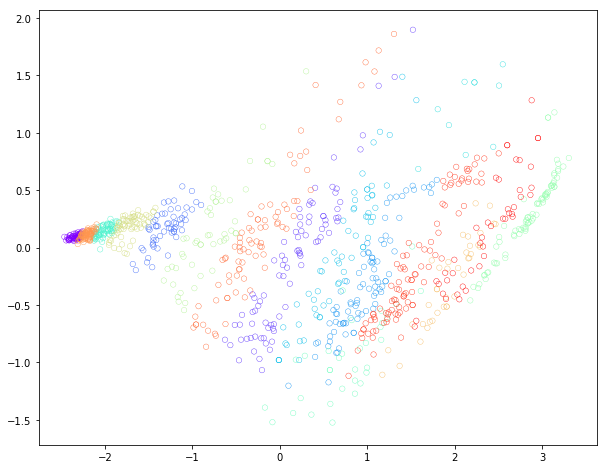

In [164]:
#Sample 1000 random indexes
plt.figure(figsize=(10,8))
sample = np.random.choice( 16384, 1000 )
plot_data(-Z_img[sample,:], 16, img_idx[sample])